### STA_141C Project Code

#### Adam Hetherwick, Sung-Woo Bak, Jonathan Casas-Ramirez, Jose Munoz

##### 3/4/24

In [1]:
import matplotlib.pyplot as plt
import kaggle
import pandas as pd
import zipfile
from cv2 import imread, IMREAD_GRAYSCALE, resize
import cv2
import os
import random
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import cross_val_score

#### Reading metadata, dataset preview etc. 

In [2]:
os.environ['KAGGLE_USERNAME'] = "adamhetherwick"
os.environ['KAGGLE_KEY'] = "d0a2f82208dfd45d107a55886935361f"

In [3]:
!kaggle datasets download -d praveengovi/coronahack-chest-xraydataset -p /content/datasets

coronahack-chest-xraydataset.zip: Skipping, found more recently modified local copy (use --force to force download)


In [4]:
zip_path = '/content/datasets/coronahack-chest-xraydataset.zip'
unzip_path = '/content/datasets/'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(unzip_path)

In [5]:
meta = pd.read_csv('/content/datasets/Chest_xray_Corona_Metadata.csv')
print(meta['Label'].unique())

['Normal' 'Pnemonia']


In [6]:
meta.head(n=3)

,Unnamed: 0,X_ray_image_name,Label,Dataset_type,Label_2_Virus_category,Label_1_Virus_category
0,0,IM-0128-0001.jpeg,Normal,TRAIN,NaN,NaN
1,1,IM-0127-0001.jpeg,Normal,TRAIN,NaN,NaN
2,2,IM-0125-0001.jpeg,Normal,TRAIN,NaN,NaN


In [7]:
meta.shape

(5910, 6)

#### Add full_path, image_matrix to meta

In [8]:
img_names = meta['X_ray_image_name']

In [9]:
train_img_folder = '/content/datasets/Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/train/'
test_img_folder = '/content/datasets/Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/test/'

paths = []
img_matrices = []

for index, img in enumerate(img_names):
    if meta['Dataset_type'][index] == 'TRAIN':
        cur_path = train_img_folder + img
    if meta['Dataset_type'][index] == 'TEST':
        cur_path = test_img_folder + img
    img_to_pixels = imread(cur_path, IMREAD_GRAYSCALE)
    paths.append(cur_path)
    img_matrices.append(img_to_pixels)

meta['full_path'] = paths
meta['image_matrix'] = img_matrices

In [10]:
def resize_image(images, dim):
  resized_imgs = []
  for img in images:
    height, width = img.shape
    if width > height:
      new_width = int(width * (dim / height))
      new_height = dim
    else:
      new_width = dim
      new_height = int(height * (dim / width))
    resized_img = cv2.resize(img, (new_width, new_height))
    start_x = (new_width - dim) // 2
    start_y = (new_height - dim) // 2
    cropped_img = resized_img[start_y:start_y + dim, start_x:start_x + dim]
    resized_imgs.append(cropped_img)
  return resized_imgs

In [11]:
resized_matrices_16 = resize_image(meta['image_matrix'], 16)
meta['image_matrix_16'] = resized_matrices_16

In [12]:
resized_matrices_32 = resize_image(meta['image_matrix'], 32)
meta['image_matrix_32'] = resized_matrices_32

In [13]:
resized_matrices_64 = resize_image(meta['image_matrix'], 64)
meta['image_matrix_64'] = resized_matrices_64

In [14]:
resized_matrices_128 = resize_image(meta['image_matrix'], 128)
meta['image_matrix_128'] = resized_matrices_128

In [15]:
# Convert factor columns from strings to factors

meta['Label'] = pd.Categorical(meta['Label'])
meta['Label_2_Virus_category'] = pd.Categorical(meta['Label_2_Virus_category'])
meta['Label_1_Virus_category'] = pd.Categorical(meta['Label_1_Virus_category'])

In [16]:
meta.head(n=3)

,Unnamed: 0,X_ray_image_name,Label,Dataset_type,Label_2_Virus_category,Label_1_Virus_category,full_path,image_matrix,image_matrix_16,image_matrix_32,image_matrix_64,image_matrix_128
0,0,IM-0128-0001.jpeg,Normal,TRAIN,NaN,NaN,/content/datasets/Coronahack-Chest-XRay-Datase...,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[39, 19, 30, 15, 111, 134, 149, 133, 123, 214...","[[37, 37, 33, 0, 3, 18, 44, 90, 102, 123, 136,...","[[43, 38, 37, 34, 33, 19, 2, 0, 0, 5, 10, 5, 5...","[[38, 33, 33, 35, 39, 37, 34, 34, 30, 29, 22, ..."
1,1,IM-0127-0001.jpeg,Normal,TRAIN,NaN,NaN,/content/datasets/Coronahack-Chest-XRay-Datase...,"[[143, 144, 147, 147, 144, 144, 144, 143, 144,...","[[117, 129, 135, 138, 140, 148, 165, 156, 167,...","[[112, 112, 119, 127, 129, 111, 112, 121, 126,...","[[115, 114, 113, 110, 112, 119, 124, 120, 121,...","[[145, 143, 145, 144, 143, 139, 136, 133, 135,..."
2,2,IM-0125-0001.jpeg,Normal,TRAIN,NaN,NaN,/content/datasets/Coronahack-Chest-XRay-Datase...,"[[75, 77, 74, 73, 74, 72, 68, 71, 67, 64, 64, ...","[[35, 19, 0, 1, 78, 90, 129, 44, 109, 127, 90,...","[[36, 19, 8, 0, 0, 0, 0, 0, 35, 75, 79, 97, 17...","[[32, 24, 11, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[26, 19, 13, 11, 2, 1, 0, 0, 0, 0, 0, 0, 0, 0..."


In [17]:
meta.iloc[-3:, :]

,Unnamed: 0,X_ray_image_name,Label,Dataset_type,Label_2_Virus_category,Label_1_Virus_category,full_path,image_matrix,image_matrix_16,image_matrix_32,image_matrix_64,image_matrix_128
5907,5930,person1634_virus_2830.jpeg,Pnemonia,TEST,NaN,Virus,/content/datasets/Coronahack-Chest-XRay-Datase...,"[[108, 109, 109, 107, 106, 107, 111, 115, 106,...","[[100, 77, 71, 48, 55, 146, 134, 157, 152, 170...","[[124, 94, 86, 64, 58, 44, 12, 6, 20, 46, 80, ...","[[113, 89, 86, 86, 79, 70, 55, 46, 43, 39, 25,...","[[105, 86, 87, 86, 88, 87, 83, 80, 73, 72, 65,..."
5908,5931,person1633_virus_2829.jpeg,Pnemonia,TEST,NaN,Virus,/content/datasets/Coronahack-Chest-XRay-Datase...,"[[0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 3, 4, 5, 7,...","[[133, 128, 140, 132, 134, 136, 145, 148, 142,...","[[129, 122, 125, 120, 124, 133, 131, 128, 131,...","[[124, 127, 122, 126, 122, 129, 126, 129, 126,...","[[122, 124, 124, 124, 119, 122, 125, 121, 124,..."
5909,5932,person1632_virus_2827.jpeg,Pnemonia,TEST,NaN,Virus,/content/datasets/Coronahack-Chest-XRay-Datase...,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[117, 139, 154, 199, 193, 185, 205, 199, 194,...","[[102, 105, 118, 142, 162, 179, 186, 187, 167,...","[[86, 81, 88, 89, 110, 135, 137, 145, 163, 168...","[[74, 79, 82, 76, 78, 78, 82, 78, 115, 111, 12..."


#### Test path and visual

Label                     Pnemonia
Dataset_type                 TRAIN
Label_2_Virus_category         NaN
Label_1_Virus_category    bacteria
Name: 4150, dtype: object
Shape: (1140, 1449)
[[0 0 0 ... 4 0 0]
 [0 0 0 ... 3 0 0]
 [0 0 0 ... 3 0 0]
 ...
 [0 2 6 ... 0 0 0]
 [0 2 6 ... 0 0 0]
 [0 2 6 ... 0 0 0]]


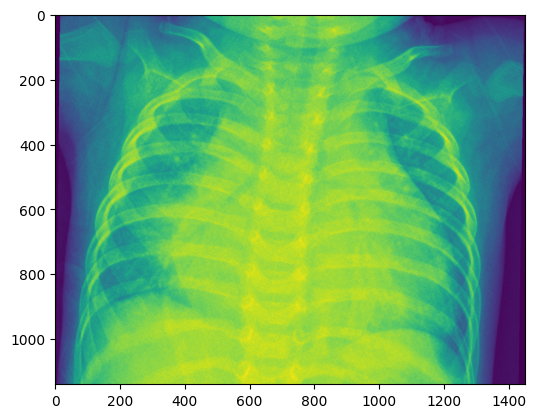

In [26]:
rand_int = random.randint(1, len(meta))

temp_image = meta['image_matrix'][rand_int]

print(meta.iloc[rand_int, [2, 3, 4, 5]])
print('Shape:', temp_image.shape)
plt.imshow(temp_image)
print(temp_image)

#### Create testing and training sets

In [94]:
train = meta[meta.Dataset_type == 'TRAIN'].reset_index(drop=True)
test = meta[meta.Dataset_type == 'TEST'].reset_index(drop=True)

In [95]:
print('train shape:', train.shape,
      '\ntest shape:', test.shape)

train shape: (5286, 13) 
test shape: (624, 13)


In [96]:
train.head(n=3)

,Unnamed: 0,X_ray_image_name,Label,Dataset_type,Label_2_Virus_category,Label_1_Virus_category,full_path,image_matrix,image_matrix_resized,image_matrix_16,image_matrix_32,image_matrix_64,image_matrix_128
0,0,IM-0128-0001.jpeg,Normal,TRAIN,NaN,NaN,/content/datasets/Coronahack-Chest-XRay-Datase...,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[37, 37, 33, 0, 3, 18, 44, 90, 102, 123, 136,...","[[39, 19, 30, 15, 111, 134, 149, 133, 123, 214...","[[37, 37, 33, 0, 3, 18, 44, 90, 102, 123, 136,...","[[43, 38, 37, 34, 33, 19, 2, 0, 0, 5, 10, 5, 5...","[[38, 33, 33, 35, 39, 37, 34, 34, 30, 29, 22, ..."
1,1,IM-0127-0001.jpeg,Normal,TRAIN,NaN,NaN,/content/datasets/Coronahack-Chest-XRay-Datase...,"[[143, 144, 147, 147, 144, 144, 144, 143, 144,...","[[112, 112, 119, 127, 129, 111, 112, 121, 126,...","[[117, 129, 135, 138, 140, 148, 165, 156, 167,...","[[112, 112, 119, 127, 129, 111, 112, 121, 126,...","[[115, 114, 113, 110, 112, 119, 124, 120, 121,...","[[145, 143, 145, 144, 143, 139, 136, 133, 135,..."
2,2,IM-0125-0001.jpeg,Normal,TRAIN,NaN,NaN,/content/datasets/Coronahack-Chest-XRay-Datase...,"[[75, 77, 74, 73, 74, 72, 68, 71, 67, 64, 64, ...","[[36, 19, 8, 0, 0, 0, 0, 0, 35, 75, 79, 97, 17...","[[35, 19, 0, 1, 78, 90, 129, 44, 109, 127, 90,...","[[36, 19, 8, 0, 0, 0, 0, 0, 35, 75, 79, 97, 17...","[[32, 24, 11, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[26, 19, 13, 11, 2, 1, 0, 0, 0, 0, 0, 0, 0, 0..."


#### Create Linear Regression model

In [111]:
lda_accuracies = []
lda_mses = []

In [105]:
# Model for full images

model_lda_full = LinearDiscriminantAnalysis()

x_train = np.array([img.flatten() for img in train['image_matrix_resized']])
y_train = [1 if y == 'Pnemonia' else 0 for y in train['Label']]

model_lda_full.fit(x_train, y_train)

x_test = np.array([img.flatten() for img in test['image_matrix_resized']])
y_test = [1 if y == 'Pnemonia' else 0 for y in test['Label']]

lda_preds = model_lda_full.predict(x_test)
lda_accuracy = sum(lda_preds == y_test)
lda_accuracy / len(y_test)

0.7467948717948718

In [113]:
# model for 16x16 images

model_lda_16 = LinearDiscriminantAnalysis()

x_train = np.array([img.flatten() for img in train['image_matrix_16']])
y_train = [1 if y == 'Pnemonia' else 0 for y in train['Label']]

model_lda_16.fit(x_train, y_train)

x_test = np.array([img.flatten() for img in test['image_matrix_16']])
y_test = [1 if y == 'Pnemonia' else 0 for y in test['Label']]

lda_preds = model_lda_16.predict(x_test)
lda_accuracy = sum(lda_preds == y_test)

accuracy = lda_accuracy / len(y_test)
mse_scores = cross_val_score(model_lda_16, x_train, y_train, cv=10, scoring='neg_mean_squared_error')
mse_scores = -mse_scores
mse = np.mean(mse_scores)

lda_accuracies.append(accuracy)
lda_mses.append(mse)

print('LDA_Accuracy_16:', accuracy)
print('LDA_MSE_16:', mse)

LDA_Accuracy_16: 0.7628205128205128
LDA_MSE_16: 0.05732299364151916


In [114]:
# model for 32x32 images

model_lda_32 = LinearDiscriminantAnalysis()

x_train = np.array([img.flatten() for img in train['image_matrix_32']])
y_train = [1 if y == 'Pnemonia' else 0 for y in train['Label']]

model_lda_32.fit(x_train, y_train)

x_test = np.array([img.flatten() for img in test['image_matrix_32']])
y_test = [1 if y == 'Pnemonia' else 0 for y in test['Label']]

lda_preds = model_lda_32.predict(x_test)
lda_accuracy = sum(lda_preds == y_test)

accuracy = lda_accuracy / len(y_test)
mse_scores = cross_val_score(model_lda_32, x_train, y_train, cv=10, scoring='neg_mean_squared_error')
mse_scores = -mse_scores
mse = np.mean(mse_scores)

lda_accuracies.append(accuracy)
lda_mses.append(mse)

print('LDA_Accuracy_32:', accuracy)
print('LDA_MSE_32:', mse)

LDA_Accuracy_32: 0.7467948717948718
LDA_MSE_32: 0.06659112390445092


In [115]:
# model for 64x64 images

model_lda_64 = LinearDiscriminantAnalysis()

x_train = np.array([img.flatten() for img in train['image_matrix_64']])
y_train = [1 if y == 'Pnemonia' else 0 for y in train['Label']]

model_lda_64.fit(x_train, y_train)

x_test = np.array([img.flatten() for img in test['image_matrix_64']])
y_test = [1 if y == 'Pnemonia' else 0 for y in test['Label']]

lda_preds = model_lda_64.predict(x_test)
lda_accuracy = sum(lda_preds == y_test)

accuracy = lda_accuracy / len(y_test)
mse_scores = cross_val_score(model_lda_64, x_train, y_train, cv=10, scoring='neg_mean_squared_error')
mse_scores = -mse_scores
mse = np.mean(mse_scores)

lda_accuracies.append(accuracy)
lda_mses.append(mse)

print('LDA_Accuracy_64:', accuracy)
print('LDA_MSE_64:', mse)

LDA_Accuracy_64: 0.7131410256410257
LDA_MSE_64: 0.23174335510110558


In [116]:
# model for 128x128 images

model_lda_128 = LinearDiscriminantAnalysis()

x_train = np.array([img.flatten() for img in train['image_matrix_128']])
y_train = [1 if y == 'Pnemonia' else 0 for y in train['Label']]

model_lda_128.fit(x_train, y_train)

x_test = np.array([img.flatten() for img in test['image_matrix_128']])
y_test = [1 if y == 'Pnemonia' else 0 for y in test['Label']]

lda_preds = model_lda_128.predict(x_test)
lda_accuracy = sum(lda_preds == y_test)

accuracy = lda_accuracy / len(y_test)
mse_scores = cross_val_score(model_lda_128, x_train, y_train, cv=10, scoring='neg_mean_squared_error')
mse_scores = -mse_scores
mse = np.mean(mse_scores)

lda_accuracies.append(accuracy)
lda_mses.append(mse)

print('LDA_Accuracy_128:', accuracy)
print('LDA_MSE_128:', mse)

LDA_Accuracy_128: 0.7580128205128205
LDA_MSE_128: 0.08191377384430314


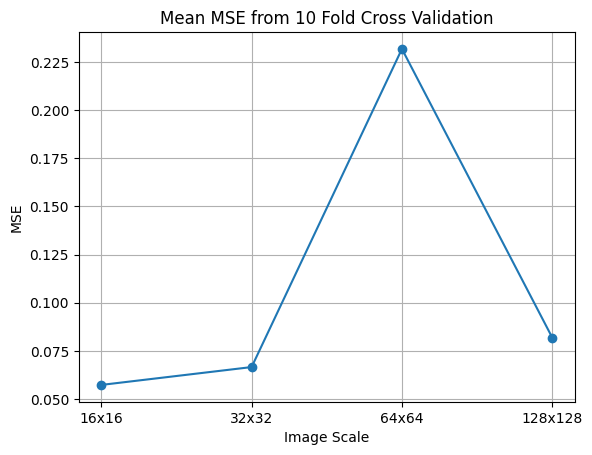

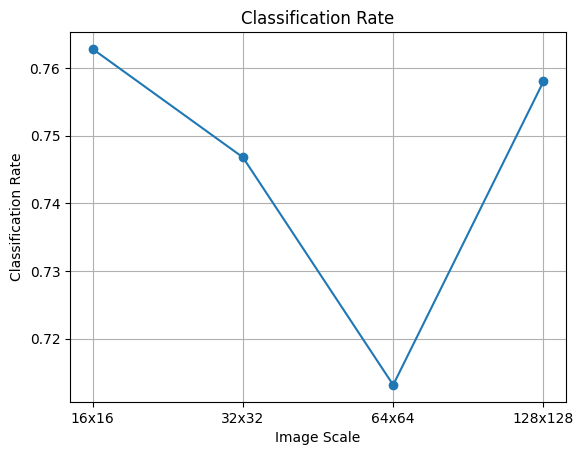

In [117]:
size = ['16x16', '32x32', '64x64' ,'128x128']

plt.plot(size, lda_mses, 'o-')
plt.title('Mean MSE from 10 Fold Cross Validation')
plt.xlabel('Image Scale')
plt.ylabel('MSE')
plt.grid()
plt.show()


plt.plot(size, lda_accuracies, 'o-')
plt.title('Classification Rate')
plt.xlabel('Image Scale')
plt.ylabel('Classification Rate')
plt.grid()
plt.show()